In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
#read the dataframe
df = pd.read_csv('/content/drive/My Drive/compas-analysis-master/compas-scores-two-years.csv')
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [3]:
df1 = df
df1.count()

id                         7214
name                       7214
first                      7214
last                       7214
compas_screening_date      7214
sex                        7214
dob                        7214
age                        7214
age_cat                    7214
race                       7214
juv_fel_count              7214
decile_score               7214
juv_misd_count             7214
juv_other_count            7214
priors_count               7214
days_b_screening_arrest    6907
c_jail_in                  6907
c_jail_out                 6907
c_case_number              7192
c_offense_date             6055
c_arrest_date              1137
c_days_from_compas         7192
c_charge_degree            7214
c_charge_desc              7185
is_recid                   7214
r_case_number              3471
r_charge_degree            3471
r_days_from_arrest         2316
r_offense_date             3471
r_charge_desc              3413
r_jail_in                  2316
r_jail_o

In [4]:
#drop irrelevant columns (columns with more than 60% NaN values)
drop_columns = ['name','first','last','c_arrest_date','r_case_number','r_charge_degree','r_days_from_arrest','r_offense_date','r_charge_desc','r_jail_in','r_jail_out','violent_recid','vr_case_number','vr_charge_degree','vr_offense_date','vr_charge_desc']
df1.drop(drop_columns, axis=1, inplace=True)
df1.head()

,id,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,is_violent_recid,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,1.0,F,Aggravated Assault w/Firearm,0,0,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,1.0,F,Felony Battery w/Prior Convict,1,1,Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,1.0,F,Possession of Cocaine,1,0,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,1.0,F,Possession of Cannabis,0,0,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,76.0,F,arrest case no charge,0,0,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [5]:
#group by age_cat variable
counts = df1.groupby('age_cat').count().sort_index()
print(counts)

                   id  compas_screening_date   sex  ...   end  event  two_year_recid
age_cat                                             ...                             
25 - 45          4109                   4109  4109  ...  4109   4109            4109
Greater than 45  1576                   1576  1576  ...  1576   1576            1576
Less than 25     1529                   1529  1529  ...  1529   1529            1529

[3 rows x 36 columns]


In [6]:
#Bar graphs for some general information about the demographic distribution
def bar_graph(df1,group_col,figsize,**kwargs):
  counts = df.groupby(group_col)['id'].count()
  fig, ax = plt.subplots(figsize=figsize)
  counts.plot(kind="bar", **kwargs)
  return fig, ax

(<Figure size 1008x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa4534347f0>)

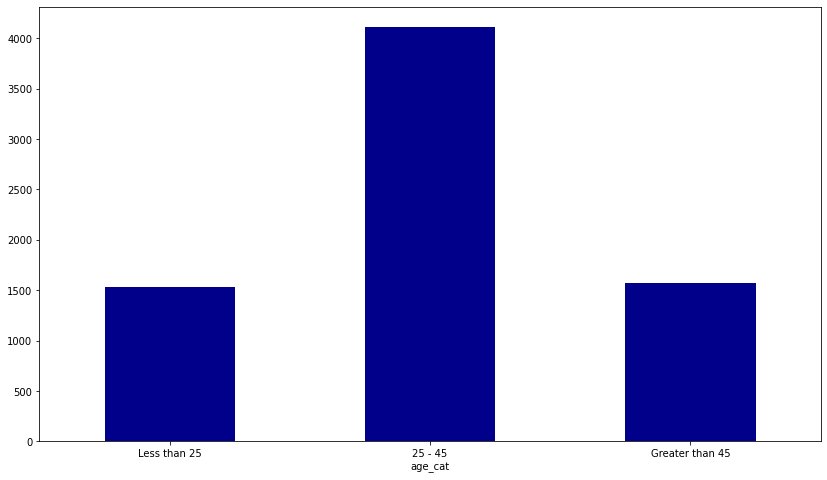

In [7]:
#Bar graph by age
age = ["Less than 25", "25 - 45", "Greater than 45"]
df1["age_cat"] = pd.Categorical(df1["age_cat"], categories=age, ordered=True)
bar_graph(df1, "age_cat", (14, 8), color="DarkBlue", rot=0)

(<Figure size 432x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa4532d9d30>)

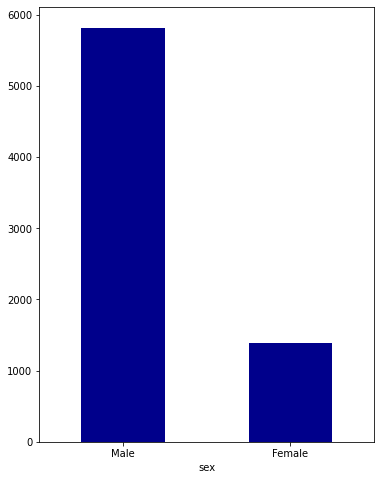

In [8]:
# Bar graph by sex
sex = ["Male", "Female"]
df1["sex"] = pd.Categorical(df1["sex"], categories=sex, ordered=True)
bar_graph(df1, "sex", (6, 8), color="DarkBlue", rot=0)

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa452d91b70>)

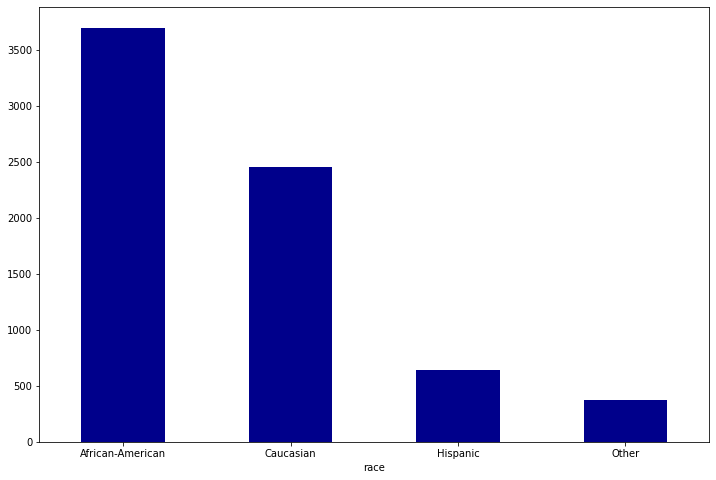

In [9]:
#Bar graph by race
race = ["African-American", "Caucasian", "Hispanic", 'Other']
df1["race"] = pd.Categorical(df1["race"], categories=race, ordered=True)
bar_graph(df1, "race", (12, 8), color="DarkBlue", rot=0)

In [10]:
recidivism = df.groupby(["age_cat", "sex", "race"])["two_year_recid"].mean().unstack(level="age_cat")
recidivism

age_cat                  Less than 25   25 - 45  Greater than 45
sex    race                                                     
Male   African-American      0.645806  0.533074         0.425101
       Caucasian             0.541254  0.433699         0.289157
       Hispanic              0.536364  0.375000         0.216667
       Other                 0.552239  0.358382         0.271429
Female African-American      0.449704  0.382278         0.227273
       Caucasian             0.310345  0.423948         0.239766
       Hispanic              0.411765  0.333333         0.217391
       Other                 0.200000  0.243243         0.200000

(<Figure size 1008x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa452d7a710>)

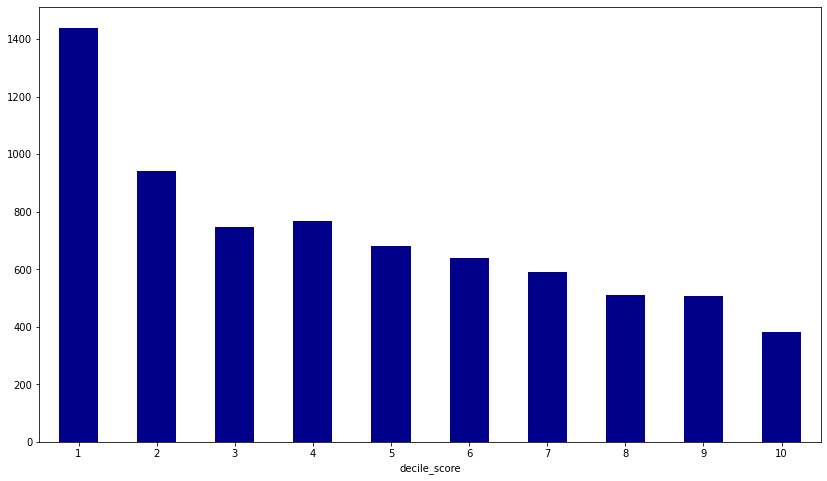

In [11]:
bar_graph(df1, "decile_score", (14, 8), color="DarkBlue", rot=0)

In [12]:
df1.groupby("decile_score")["two_year_recid"].mean()

decile_score
1     0.213889
2     0.311371
3     0.376171
4     0.434330
5     0.478708
6     0.558502
7     0.591216
8     0.683594
9     0.698819
10    0.772846
Name: two_year_recid, dtype: float64

In [13]:
#Corr between decile score and two_year_recid
df1[["decile_score", "two_year_recid"]].corr()

,decile_score,two_year_recid
decile_score,1.000000,0.350703
two_year_recid,0.350703,1.000000


In [14]:
#rate of recidivism using decile score and race (we can see that for most part as decile score increases rate of recidivism increases)
rate_recidivism = df.pivot_table(index="decile_score", columns="race", values="two_year_recid")
rate_recidivism

race,African-American,Caucasian,Hispanic,Other
decile_score,,,,
1,0.228643,0.208517,0.244898,0.173333
2,0.302799,0.313019,0.318584,0.378788
3,0.419075,0.340659,0.313953,0.388889
4,0.459740,0.396491,0.346154,0.543478
5,0.482192,0.460581,0.538462,0.454545
6,0.559896,0.572165,0.567568,0.380952
7,0.592500,0.615385,0.470588,0.500000
8,0.682451,0.719298,0.500000,0.800000
9,0.707895,0.693878,0.550000,0.750000


In [15]:
df1.race.value_counts(dropna=False)

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
NaN                   50
Name: race, dtype: int64

In [16]:
values = {'race' : 'Other'}
df1 = df1.fillna(value=values)

In [17]:
df1.race.value_counts(dropna=False)

African-American    3696
Caucasian           2454
Hispanic             637
Other                427
Name: race, dtype: int64

In [18]:
drop_columns1 = ['juv_fel_count','juv_misd_count','juv_other_count']
df1.drop(drop_columns1, axis=1, inplace=True)

In [20]:
df1.drop(['c_case_number'],axis=1,inplace=True)

In [21]:
df1.c_charge_degree.value_counts()

F    4666
M    2548
Name: c_charge_degree, dtype: int64

In [22]:
df1.days_b_screening_arrest.value_counts()

-1.0      3980
 0.0      1379
-2.0       150
-3.0        96
-4.0        63
          ... 
 90.0        1
 336.0       1
-118.0       1
 17.0        1
 657.0       1
Name: days_b_screening_arrest, Length: 423, dtype: int64

In [23]:
df1.c_charge_desc.value_counts()

Battery                           1156
arrest case no charge             1137
Possession of Cocaine              474
Grand Theft in the 3rd Degree      425
Driving While License Revoked      200
                                  ... 
Possess w/I/Utter Forged Bills       1
Possession Of Buprenorphine          1
Unlaw Lic Use/Disply Of Others       1
Del Morphine at/near Park            1
Carjacking with a Firearm            1
Name: c_charge_desc, Length: 437, dtype: int64

In [24]:
df1.type_of_assessment.value_counts()

Risk of Recidivism    7214
Name: type_of_assessment, dtype: int64

In [25]:
df1.drop(['type_of_assessment'],axis=1,inplace=True)

In [26]:
df1.drop(['v_type_of_assessment'],axis=1,inplace=True)

In [27]:
drop_columns3 = ['compas_screening_date','c_days_from_compas','is_recid','is_violent_recid','decile_score.1','v_decile_score','v_score_text','v_screening_date','priors_count.1']
df1.drop(drop_columns3,axis=1,inplace=True)

In [28]:
df1.dropna(subset = ["c_jail_in"], inplace=True)

In [29]:
df1.dropna(subset = ["c_charge_desc"], inplace=True)

In [35]:
df1.count()

id                         6900
sex                        6900
dob                        6900
age                        6900
age_cat                    6900
race                       6900
decile_score               6900
priors_count               6900
days_b_screening_arrest    6900
c_jail_in                  6900
c_jail_out                 6900
c_charge_degree            6900
c_charge_desc              6900
score_text                 6900
screening_date             6900
in_custody                 6900
out_custody                6900
start                      6900
end                        6900
event                      6900
two_year_recid             6900
dtype: int64

In [36]:
#final check for NaN values in df1
df1.isnull().values.any()

False

In [37]:
df1.drop(['id'],axis=1,inplace=True)

In [38]:
one_hot_df1_sex = pd.get_dummies(df1.sex)
df1 = pd.concat([df1, one_hot_df1_sex], axis=1, sort=False)
df1.drop(['sex'], axis=1, inplace=True)

In [39]:
one_hot_df1_race = pd.get_dummies(df1.race)
df1 = pd.concat([df1, one_hot_df1_race], axis=1, sort=False)
df1.drop(['race'], axis=1, inplace=True)

In [40]:
one_hot_df1_cchargedegree = pd.get_dummies(df1.c_charge_degree)
df1 = pd.concat([df1, one_hot_df1_cchargedegree], axis=1, sort=False)
df1.drop(['c_charge_degree'], axis=1, inplace=True)

In [41]:
df1.drop(['dob'],axis=1,inplace=True)

In [42]:
df1.dtypes

age                           int64
age_cat                    category
decile_score                  int64
priors_count                  int64
days_b_screening_arrest     float64
c_jail_in                    object
c_jail_out                   object
c_charge_desc                object
score_text                   object
screening_date               object
in_custody                   object
out_custody                  object
start                         int64
end                           int64
event                         int64
two_year_recid                int64
Male                          uint8
Female                        uint8
African-American              uint8
Caucasian                     uint8
Hispanic                      uint8
Other                         uint8
F                             uint8
M                             uint8
dtype: object

In [43]:
df1['c_jail_in'] = pd.to_datetime(df1.c_jail_in).astype('int')/(10**9)

In [44]:
df1['c_jail_out'] = pd.to_datetime(df1.c_jail_out).astype('int')/(10**9)

In [45]:
df1.dtypes

age                           int64
age_cat                    category
decile_score                  int64
priors_count                  int64
days_b_screening_arrest     float64
c_jail_in                   float64
c_jail_out                  float64
c_charge_desc                object
score_text                   object
screening_date               object
in_custody                   object
out_custody                  object
start                         int64
end                           int64
event                         int64
two_year_recid                int64
Male                          uint8
Female                        uint8
African-American              uint8
Caucasian                     uint8
Hispanic                      uint8
Other                         uint8
F                             uint8
M                             uint8
dtype: object

In [46]:
df1['time_in_jail'] = df1['c_jail_out'] - df1['c_jail_in']

In [47]:
df1.head()

,age,age_cat,decile_score,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_charge_desc,score_text,screening_date,in_custody,out_custody,start,end,event,two_year_recid,Male,Female,African-American,Caucasian,Hispanic,Other,F,M,time_in_jail
0,69,Greater than 45,1,0,-1.0,1.376374e+09,1.376459e+09,Aggravated Assault w/Firearm,Low,2013-08-14,2014-07-07,2014-07-14,0,327,0,0,1,0,0,0,0,1,1,0,85058.0
1,34,25 - 45,3,0,-1.0,1.359172e+09,1.360043e+09,Felony Battery w/Prior Convict,Low,2013-01-27,2013-01-26,2013-02-05,9,159,1,1,1,0,1,0,0,0,1,0,870686.0
2,24,Less than 25,4,4,-1.0,1.365829e+09,1.365923e+09,Possession of Cocaine,Low,2013-04-14,2013-06-16,2013-06-16,0,63,0,1,1,0,1,0,0,0,1,0,93810.0
5,44,25 - 45,1,0,0.0,1.385787e+09,1.385901e+09,Battery,Low,2013-11-30,2013-11-30,2013-12-01,1,853,0,0,1,0,0,0,0,1,0,1,113918.0
6,41,25 - 45,6,14,-1.0,1.392700e+09,1.393244e+09,Possession Burglary Tools,Medium,2014-02-19,2014-03-31,2014-04-18,5,40,1,1,1,0,0,1,0,0,1,0,544206.0


In [ ]:
#df3 = df1

In [48]:
df1.drop(['c_jail_in','c_jail_out'], axis=1, inplace = True)

In [49]:
df1['in_custody'] = pd.to_datetime(df1.in_custody).astype('int')/(10**9)

In [50]:
df1['out_custody'] = pd.to_datetime(df1.out_custody).astype('int')/(10**9)

In [51]:
df1['time_in_custody'] = df1['out_custody'] - df1['in_custody']

In [52]:
df1.drop(['in_custody','out_custody'], axis=1, inplace = True)

In [53]:
df1['screening_date'] = pd.to_datetime(df1.screening_date).astype('int')/(10**9)

In [54]:
df1.dtypes

age                           int64
age_cat                    category
decile_score                  int64
priors_count                  int64
days_b_screening_arrest     float64
c_charge_desc                object
score_text                   object
screening_date              float64
start                         int64
end                           int64
event                         int64
two_year_recid                int64
Male                          uint8
Female                        uint8
African-American              uint8
Caucasian                     uint8
Hispanic                      uint8
Other                         uint8
F                             uint8
M                             uint8
time_in_jail                float64
time_in_custody             float64
dtype: object

(<Figure size 1152x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa451713668>)

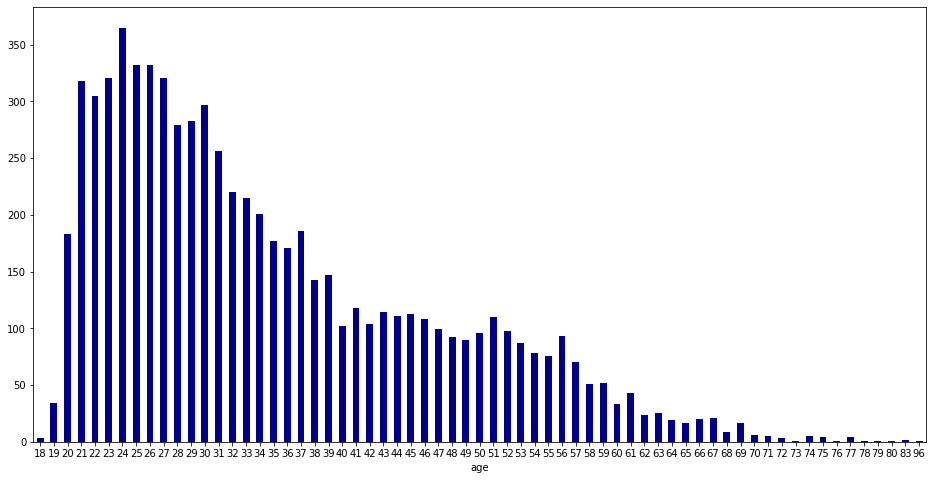

In [55]:
bar_graph(df1, "age", (16, 8), color="DarkBlue", rot=0)

In [56]:
is_1 = df1['two_year_recid'] == 1
df1[is_1].age.value_counts()

24    181
21    178
27    176
26    166
22    165
25    163
23    161
30    145
29    142
28    136
20    131
31    124
32    104
33     99
34     88
36     76
37     70
35     66
38     57
39     48
43     47
41     45
44     40
47     39
51     39
46     38
50     37
45     36
52     35
42     35
19     33
48     31
40     30
49     28
55     25
54     23
56     21
53     21
59     19
57     18
58     17
61     12
60      8
66      6
63      6
69      5
62      5
65      4
64      4
67      3
18      3
77      1
68      1
70      1
78      1
75      1
96      1
Name: age, dtype: int64

In [57]:
df1.drop(['age'],axis=1,inplace=True)

In [58]:
one_hot_df1_agecat = pd.get_dummies(df1.age_cat)
df1 = pd.concat([df1, one_hot_df1_agecat], axis=1, sort=False)
df1.drop(['age_cat'], axis=1, inplace=True)

In [60]:
one_hot_df1_scoretext = pd.get_dummies(df1.score_text)
df1 = pd.concat([df1, one_hot_df1_scoretext], axis=1, sort=False)
df1.drop(['score_text'], axis=1, inplace=True)
df1.drop(['decile_score'], axis=1, inplace=True)

In [62]:
#df1.c_charge_desc = df1.c_charge_desc.fillna("")
df1["charge_cat"] = df1.c_charge_desc
cnt = df1.c_charge_desc.value_counts()[df1.c_charge_desc]
#print(cnt)
cnt.index = df1.index
df1.loc[cnt<10,"charge_cat"] = "other"
df1.charge_cat = df1.charge_cat.astype('category')

In [63]:
df1.head()

,priors_count,days_b_screening_arrest,c_charge_desc,screening_date,start,end,event,two_year_recid,Male,Female,African-American,Caucasian,Hispanic,Other,F,M,time_in_jail,time_in_custody,Less than 25,25 - 45,Greater than 45,High,Low,Medium,charge_cat
0,0,-1.0,Aggravated Assault w/Firearm,1.376438e+09,0,327,0,0,1,0,0,0,0,1,1,0,85058.0,604800.0,0,0,1,0,1,0,Aggravated Assault w/Firearm
1,0,-1.0,Felony Battery w/Prior Convict,1.359245e+09,9,159,1,1,1,0,1,0,0,0,1,0,870686.0,864000.0,0,1,0,0,1,0,Felony Battery w/Prior Convict
2,4,-1.0,Possession of Cocaine,1.365898e+09,0,63,0,1,1,0,1,0,0,0,1,0,93810.0,0.0,1,0,0,0,1,0,Possession of Cocaine
5,0,0.0,Battery,1.385770e+09,1,853,0,0,1,0,0,0,0,1,0,1,113918.0,86400.0,0,1,0,0,1,0,Battery
6,14,-1.0,Possession Burglary Tools,1.392768e+09,5,40,1,1,1,0,0,1,0,0,1,0,544206.0,1555200.0,0,1,0,0,0,1,Possession Burglary Tools


In [64]:
df1.charge_cat.value_counts()

Battery                          1125
arrest case no charge            1052
other                             740
Possession of Cocaine             464
Grand Theft in the 3rd Degree     420
                                 ... 
Cruelty Toward Child               11
Leave Acc/Attend Veh/More $50      10
Poss 3,4 MDMA (Ecstasy)            10
Leaving Acc/Unattended Veh         10
Criminal Mischief>$200<$1000       10
Name: charge_cat, Length: 88, dtype: int64

In [65]:
df1.dtypes

priors_count                  int64
days_b_screening_arrest     float64
c_charge_desc                object
screening_date              float64
start                         int64
end                           int64
event                         int64
two_year_recid                int64
Male                          uint8
Female                        uint8
African-American              uint8
Caucasian                     uint8
Hispanic                      uint8
Other                         uint8
F                             uint8
M                             uint8
time_in_jail                float64
time_in_custody             float64
Less than 25                  uint8
25 - 45                       uint8
Greater than 45               uint8
High                          uint8
Low                           uint8
Medium                        uint8
charge_cat                 category
dtype: object

In [66]:
df1.shape

(6900, 25)

In [67]:
df1.drop(['c_charge_desc','charge_cat'],axis=1,inplace=True)

In [68]:
df1.head()

,priors_count,days_b_screening_arrest,screening_date,start,end,event,two_year_recid,Male,Female,African-American,Caucasian,Hispanic,Other,F,M,time_in_jail,time_in_custody,Less than 25,25 - 45,Greater than 45,High,Low,Medium
0,0,-1.0,1.376438e+09,0,327,0,0,1,0,0,0,0,1,1,0,85058.0,604800.0,0,0,1,0,1,0
1,0,-1.0,1.359245e+09,9,159,1,1,1,0,1,0,0,0,1,0,870686.0,864000.0,0,1,0,0,1,0
2,4,-1.0,1.365898e+09,0,63,0,1,1,0,1,0,0,0,1,0,93810.0,0.0,1,0,0,0,1,0
5,0,0.0,1.385770e+09,1,853,0,0,1,0,0,0,0,1,0,1,113918.0,86400.0,0,1,0,0,1,0
6,14,-1.0,1.392768e+09,5,40,1,1,1,0,0,1,0,0,1,0,544206.0,1555200.0,0,1,0,0,0,1


In [ ]:
#x = df1.values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(x)
#df1 = pd.DataFrame(x_scaled)

In [ ]:
#df1.head()
#X = df1.drop(['two_year_recid'],axis=1,inplace=True)
#y = np.array(df1['two_year_recid'],axis=1)

In [69]:
df1.drop(['event','start','end'],axis=1,inplace=True)

In [ ]:
#df1[["end", "two_year_recid"]].corr()

In [70]:
X = df1.drop(['two_year_recid'],axis=1)
y = df1['two_year_recid']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
from sklearn import preprocessing 
trainX1_norm = preprocessing.scale(X_train)
testX1_norm = preprocessing.scale(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [73]:
n_estimators_rf = [50,70,100,120,150]
quality_of_split_rf = ['entropy','gini']
column_name_rf = ['Accuracy Score','Criterion','n_estimators']
lst_rf = []
accuracyList_rf = [-1] #because accuracy can never be -1
for n_estimators in n_estimators_rf:
  for criterion in quality_of_split_rf:
    clf_rf = RandomForestClassifier(criterion=criterion,n_estimators=n_estimators)
    rf = clf_rf.fit(trainX1_norm,y_train)
    y_pred_rf = rf.predict(testX1_norm)
    Accuracy_score_rf = accuracy_score(y_test,y_pred_rf)
    if(Accuracy_score_rf > max(accuracyList_rf)):
      yFinal_rf = y_pred_rf
    accuracyList_rf.append(Accuracy_score_rf)
    lst_rf.append([Accuracy_score_rf,criterion,n_estimators])
    df_rf = pd.DataFrame(lst_rf,columns = column_name_rf)

print(df_rf[df_rf['Accuracy Score']==df_rf['Accuracy Score'].max()])
print("\nNumber of mislabeled points out of %d total points : %d"% ( testX1_norm.shape[0], (y_test!=   yFinal_rf).sum()))
print("\nPrediction of y by Decision tree model:\n",yFinal_rf)
print("\nConfusion Matrix for Decision Tree model:\n",confusion_matrix(y_test, yFinal_rf))


   Accuracy Score Criterion  n_estimators
2        0.726812   entropy            70

Number of mislabeled points out of 1380 total points : 377

Prediction of y by Decision tree model:
 [1 0 1 ... 1 0 0]

Confusion Matrix for Decision Tree model:
 [[551 196]
 [181 452]]


In [74]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, yFinal_rf)

0.7258385834015367

In [75]:
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.10627
Feature: 1, Score: 0.07233
Feature: 2, Score: 0.31813
Feature: 3, Score: 0.00937
Feature: 4, Score: 0.00972
Feature: 5, Score: 0.01349
Feature: 6, Score: 0.01250
Feature: 7, Score: 0.00825
Feature: 8, Score: 0.00608
Feature: 9, Score: 0.01105
Feature: 10, Score: 0.01123
Feature: 11, Score: 0.17351
Feature: 12, Score: 0.12617
Feature: 13, Score: 0.01342
Feature: 14, Score: 0.01100
Feature: 15, Score: 0.01142
Feature: 16, Score: 0.02560
Feature: 17, Score: 0.04781
Feature: 18, Score: 0.01266


In [76]:
print(df1.corr(method="kendall")['two_year_recid'].sort_values(ascending=False))

two_year_recid             1.000000
priors_count               0.274181
High                       0.270547
screening_date             0.201785
time_in_custody            0.200852
African-American           0.135253
time_in_jail               0.131122
Less than 25               0.114122
Medium                     0.113687
F                          0.108200
Male                       0.093681
days_b_screening_arrest    0.062179
25 - 45                    0.020776
Other                     -0.050426
Hispanic                  -0.050558
Caucasian                 -0.087652
Female                    -0.093681
M                         -0.108200
Greater than 45           -0.139658
Low                       -0.315364
Name: two_year_recid, dtype: float64


In [77]:
column_name_lr = ['Accuracy Score']
lst_lr = []
accuracyList_lr = [-1]

lr = LogisticRegression(random_state=0)
clf_lr = lr.fit(trainX1_norm,y_train)
y_pred_lr = clf_lr.predict(testX1_norm)
Accuracy_score_lr = accuracy_score(y_test,y_pred_lr)
if(Accuracy_score_lr > max(accuracyList_lr)):
  yFinal_lr = y_pred_lr
accuracyList_lr.append(Accuracy_score_lr)
lst_lr.append([Accuracy_score_lr])
df_lr = pd.DataFrame(lst_lr,columns = column_name_lr)

print(df_lr[df_lr['Accuracy Score']==df_lr['Accuracy Score'].max()])
print("\nNumber of mislabeled points out of %d total points : %d"% ( testX1_norm.shape[0], (y_test!=   yFinal_lr).sum()))
print("\nPrediction of y by Logistic Regression model:\n",yFinal_lr)
print("\nConfusion Matrix for Logistic Regression model:\n",confusion_matrix(y_test, yFinal_lr))

   Accuracy Score
0        0.718116

Number of mislabeled points out of 1380 total points : 389

Prediction of y by Logistic Regression model:
 [1 0 1 ... 1 0 1]

Confusion Matrix for Logistic Regression model:
 [[594 153]
 [236 397]]


In [78]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, yFinal_lr)

0.7111764593920706

In [79]:
from sklearn.ensemble import AdaBoostClassifier
column_name_ab = ['Accuracy Score']
lst_ab = []
accuracyList_ab = [-1]
ab = AdaBoostClassifier(n_estimators=200)
clf_ab = ab.fit(trainX1_norm,y_train)
y_pred_ab = clf_ab.predict(testX1_norm)
Accuracy_score_ab = accuracy_score(y_test,y_pred_ab)
if(Accuracy_score_ab > max(accuracyList_ab)):
  yFinal_ab = y_pred_ab
accuracyList_ab.append(Accuracy_score_ab)
lst_ab.append([Accuracy_score_ab])
df_ab = pd.DataFrame(lst_ab,columns = column_name_ab)

print(df_ab[df_ab['Accuracy Score']==df_ab['Accuracy Score'].max()])
print("\nNumber of mislabeled points out of %d total points : %d"% ( testX1_norm.shape[0], (y_test!=   yFinal_ab).sum()))
print("\nPrediction of y by AdaBoost Classifier model:\n",yFinal_ab)
print("\nConfusion Matrix for Logistic Regression model:\n",confusion_matrix(y_test, yFinal_ab))

   Accuracy Score
0        0.734783

Number of mislabeled points out of 1380 total points : 366

Prediction of y by AdaBoost Classifier model:
 [1 0 1 ... 1 0 0]

Confusion Matrix for Logistic Regression model:
 [[577 170]
 [196 437]]


In [80]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, yFinal_ab)

0.7313931872830977

In [81]:
importance = clf_ab.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.12000
Feature: 1, Score: 0.22500
Feature: 2, Score: 0.12500
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00500
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.32500
Feature: 12, Score: 0.15500
Feature: 13, Score: 0.01000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.01000
Feature: 16, Score: 0.00500
Feature: 17, Score: 0.01500
Feature: 18, Score: 0.00500
